<a href="https://colab.research.google.com/github/Abhishek-TyRnT/TyRnT/blob/master/Malaria_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow_addons

     |████████████████████████████████| 1.0MB 2.8MB/s 


In [2]:
pip install --upgrade tensorflow

     |████████████████████████████████| 421.8MB 38kB/s 
     |████████████████████████████████| 450kB 43.3MB/s 
     |████████████████████████████████| 3.9MB 44.8MB/s 
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link="https://drive.google.com/open?id=1FoZ5XNPxsKB75bq7zYZ8rpH5PJoRB988"
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('cell_images.zip')

In [0]:
from zipfile import ZipFile
with ZipFile("cell_images.zip",'r') as zip:
  zip.extractall()

In [0]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
data_dir="cell_images"
category_1="Parasitized"
category_2="Uninfected"
path_1=os.path.join(data_dir,category_1)
path_2=os.path.join(data_dir,category_2)
def image_generator(start,stop):
 for j in range(start,stop):
   image_1=cv2.imread(os.path.join(path_1,os.listdir(path_1)[j]),cv2.IMREAD_COLOR)
   image_1=tf.image.resize(images=image_1,size=[224,224])
   image_1=tf.reshape(image_1,shape=(224,224,3))
   image_2=cv2.imread(os.path.join(path_2,os.listdir(path_2)[j]),cv2.IMREAD_COLOR)
   image_2=tf.image.resize(images=image_2,size=[224,224])
   image_2=tf.reshape(image_2,shape=(224,224,3))
   yield image_1/255,[1,0]
   if (j<(0.2*(3445))):
     x,y=tf.random.uniform(shape=(2,),minval=-20,maxval=20,dtype=tf.int32)
     roll_image_1=tf.roll(tf.roll(image_1,shift=x,axis=0),shift=y,axis=1)
     roll_image_2=tf.roll(tf.roll(image_2,shift=x,axis=0),shift=y,axis=1)
     yield roll_image_1/255,[1,0]
     yield roll_image_2/255,[0,1]
     rot_shift=tf.random.uniform(shape=(1,),minval=0,maxval=360,dtype=tf.float32)
     rot_image_1=tfa.image.rotate(image_1,angles=rot_shift)
     rot_image_2=tfa.image.rotate(image_2,angles=rot_shift)
     yield rot_image_1/255,[1,0]
     yield rot_image_2/255,[0,1]
   yield image_2/255,[0,1]


In [0]:
dataset_train=tf.data.Dataset.from_generator(image_generator,args=[0,13780//2],output_types=(tf.float32,tf.int32),output_shapes=(tf.TensorShape([224,224,3]),tf.TensorShape([2])))
dataset_val=tf.data.Dataset.from_generator(image_generator,args=[(13780//2)+1,13780],output_types=(tf.float32,tf.int32),output_shapes=(tf.TensorShape([224,224,3]),tf.TensorShape([2])))

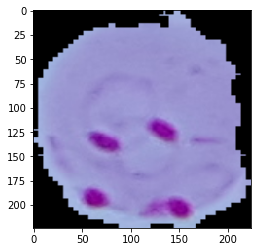

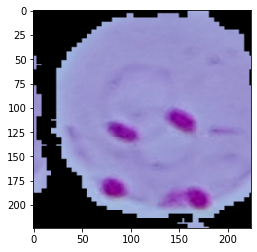

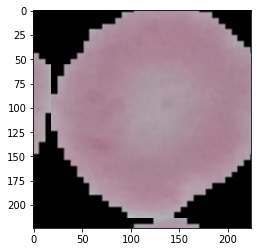

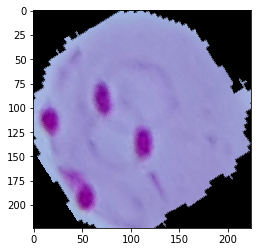

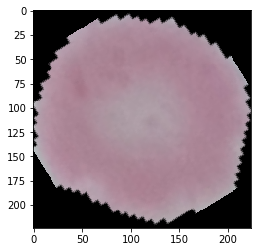

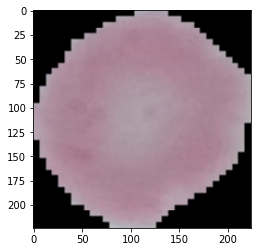

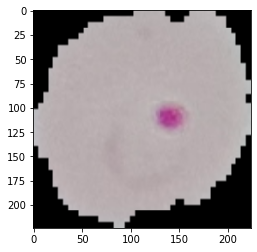

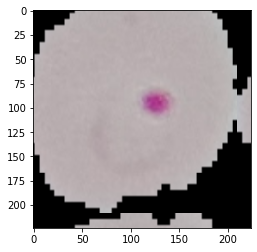

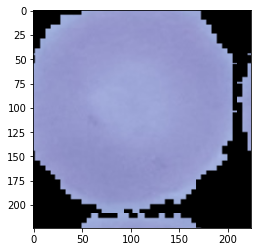

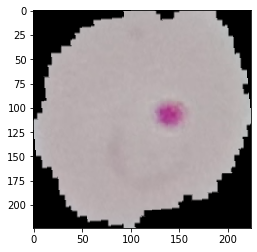

In [24]:

for img in dataset_train.take(10):
  plt.imshow(img[0])
  plt.show()

In [0]:
dataset_train=dataset_train.shuffle(100).repeat().batch(10)
dataset_val=dataset_val.shuffle(100).repeat().batch(10)

GOOGLE net

In [0]:
from tensorflow.keras import layers
class inception(layers.Layer):
  def __init__(self,filter_1,filter_2,filter_3,filter_4,filter_5,filter_6):
    super(inception,self).__init__(name='')
    self.filter_1=filter_1
    self.filter_2=filter_2
    self.filter_3=filter_3
    self.filter_4=filter_4
    self.filter_5=filter_5
    self.filter_6=filter_6
    self.conv_1_5=tf.keras.layers.Conv2D(filters=self.filter_5,strides=1,kernel_size=(1,1),padding='SAME',activation='relu',kernel_initializer=tf.keras.initializers.he_normal())
    self.conv_1_6=tf.keras.layers.Conv2D(filters=self.filter_6,strides=1,kernel_size=(1,1),padding='SAME',activation='relu',kernel_initializer=tf.keras.initializers.he_normal())
    self.max_pool_1=tf.keras.layers.MaxPool2D(pool_size=(3,3),strides=1,padding='SAME')
    self.conv_2_1=tf.keras.layers.Conv2D(filters=self.filter_1,strides=1,kernel_size=(1,1),padding='SAME',activation='relu',kernel_initializer=tf.keras.initializers.he_normal())
    self.conv_2_2=tf.keras.layers.Conv2D(filters=self.filter_2,strides=1,kernel_size=(3,3),padding='SAME',activation='relu',kernel_initializer=tf.keras.initializers.he_normal())
    self.conv_2_3=tf.keras.layers.Conv2D(filters=self.filter_3,strides=1,kernel_size=(5,5),padding='SAME',activation='relu',kernel_initializer=tf.keras.initializers.he_normal())
    self.conv_2_4=tf.keras.layers.Conv2D(filters=self.filter_4,strides=1,kernel_size=(1,1),padding='SAME',activation='relu',kernel_initializer=tf.keras.initializers.he_normal())
  def call(self,network):
    input_1=self.conv_1_5(network)
    input_2=self.conv_1_6(network)
    input_3=self.max_pool_1(network)
    input_4=self.conv_2_1(network)
    input_1=self.conv_2_2(input_1)
    input_2=self.conv_2_3(input_2)
    input_3=self.conv_2_4(input_2)
    x=tf.keras.layers.concatenate([input_4,input_3,input_2,input_1],axis=-1)
    return x



In [0]:
from tensorflow.keras import Model

inp=tf.keras.Input(shape=(224,224,3),dtype=tf.float32)
network=tf.keras.layers.Conv2D(filters=64,kernel_size=(7,7),strides=2,padding='SAME',activation='relu',kernel_initializer=tf.keras.initializers.he_normal())(inp)
network=tf.keras.layers.MaxPool2D(pool_size=(3,3),strides=2)(network)
network=tf.nn.local_response_normalization(network,depth_radius=2,alpha=0.00002,beta=0.75)
network=tf.keras.layers.Conv2D(filters=64,kernel_size=(1,1),strides=1,padding='SAME',activation='relu',kernel_initializer=tf.keras.initializers.he_normal())(network)
network=tf.keras.layers.Conv2D(filters=192,kernel_size=(3,3),strides=1,padding='SAME',activation='relu',kernel_initializer=tf.keras.initializers.he_normal())(network)
network=tf.nn.local_response_normalization(network,depth_radius=2,alpha=0.00002,beta=0.75)
network=tf.keras.layers.MaxPool2D(pool_size=(3,3),strides=2)(network)
network=inception(64,128,32,32,96,16)(network)
network=inception(128,192,96,64,128,32)(network)
network=tf.keras.layers.MaxPool2D(pool_size=(3,3),strides=2)(network)
network=inception(192,208,48,64,128,32)(network)
network=inception(160,224,64,64,112,24)(network)
network=inception(128,256,64,64,128,24)(network)
network=inception(112,288,64,64,144,32)(network)
network=inception(256,320,128,128,160,32)(network)
network=tf.keras.layers.MaxPool2D(pool_size=(3,3),strides=2)(network)
network=inception(256,320,128,128,160,32)(network)
network=inception(384,384,128,128,192,48)(network)
network=tf.keras.layers.GlobalAveragePooling2D(data_format="channels_last")(network)
network=tf.keras.layers.Dropout(0.4)(network)
network=tf.keras.layers.Flatten()(network)
output=tf.keras.layers.Dense(units=2,activation="softmax",kernel_initializer=tf.keras.initializers.TruncatedNormal())(network)
model=Model(inputs=inp,outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=tf.keras.losses.MeanSquaredError(),metrics=["accuracy"])


In [55]:
history=model.fit_generator(dataset_train,epochs=10,validation_data=dataset_val,steps_per_epoch=1378,validation_steps=100)

Train for 1378 steps, validate for 100 steps
Epoch 1/10
1378/1378 [==============================] - 329s 239ms/step - loss: 0.1332 - accuracy: 0.7887 - val_loss: 0.0388 - val_accuracy: 0.9580
Epoch 2/10
1378/1378 [==============================] - 323s 234ms/step - loss: 0.0432 - accuracy: 0.9509 - val_loss: 0.0412 - val_accuracy: 0.9450
Epoch 3/10
1378/1378 [==============================] - 323s 234ms/step - loss: 0.0391 - accuracy: 0.9537 - val_loss: 0.0325 - val_accuracy: 0.9610
Epoch 4/10
1378/1378 [==============================] - 325s 236ms/step - loss: 0.0381 - accuracy: 0.9546 - val_loss: 0.0342 - val_accuracy: 0.9610
Epoch 5/10
1378/1378 [==============================] - 328s 238ms/step - loss: 0.0339 - accuracy: 0.9603 - val_loss: 0.0413 - val_accuracy: 0.9540
Epoch 6/10
1378/1378 [==============================] - 332s 241ms/step - loss: 0.0373 - accuracy: 0.9562 - val_loss: 0.0306 - val_accuracy: 0.9630
Epoch 7/10
1378/1378 [==============================] - 323s 234ms/

In [60]:
model.evaluate(dataset_val.repeat(),steps=474)

474/474 [==============================] - 85s 180ms/step - loss: 0.0355 - accuracy: 0.9572


[0.035463875589363245, 0.957173]

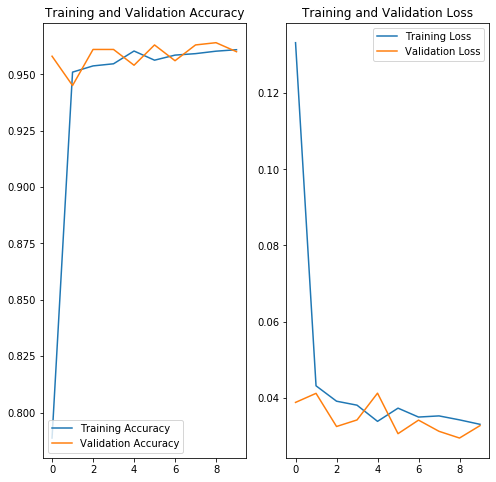

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
pip install --upgrade tensorflow

     |████████████████████████████████| 421.8MB 30kB/s 
     |████████████████████████████████| 450kB 53.1MB/s 
     |████████████████████████████████| 3.8MB 49.1MB/s 
     |████████████████████████████████| 81kB 8.8MB/s 
ERROR: tensorboard 2.1.0 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstall